<a href="https://colab.research.google.com/github/nathaliavasconcelos-create/MVP_SMSSpamAnalysis.ipynb/blob/main/MVP_SMSSpamAnalysis.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# MVP - Análise de potenciais SPAMs em SMS

Aluna: Nathalia Vasconcelos Cardoso Rodrigues

# 1. Introdução
O presente MVP tem como objetivo analisar o dataset referente a mensagens de texto, doravante SMSs, mensagens de texto, contendo potenciais conteúdos de SPAM. O dataset foi obtido a partir do link: https://www.kaggle.com/datasets/uciml/sms-spam-collection-dataset. Além disso, é possível encontrá-lo disponível no repositório UC Irvine.

Para resolver o problema de classificação proposto, serão adotados alguns algoritmos de classificação, a saber: SVM, Random Forest, KNN e Naive Bayes. Após a aplicação de cada algoritmo, os resultados obtidos serão comparados, de modo a observar os melhores desempenhos.

Relevância

A seguir, apresenta-se o código gerado para trabalhar o problema de classificação de mensagens de texto em "spam" ou "ham" (não-spam). É importante destacar que foram adotadas duas estratégias: divisão do conjunto de dados em training e teste e uso da validação cruzada.



*   Imports necessários



In [11]:
#Imports necessários
import pandas as pd #import da biblioteca Panda
import string
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import cross_val_score, StratifiedKFold #para realizar a validação cruzada
from sklearn.neighbors import KNeighborsClassifier #para importar algoritmo KNN
from sklearn.naive_bayes import GaussianNB #para importar algoritmo Naive Bayes
from sklearn.tree import DecisionTreeClassifier #para importar o algoritmo Árvore de Classificação
from sklearn.svm import SVC #para importar o algoritmo SVM
from sklearn.linear_model import LogisticRegression #para importar o algoritmo de Regressão Logística
from sklearn.ensemble import RandomForestClassifier #para importar o algoritmo Random Forest
from sklearn.datasets import load_digits
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix #para a exibição da acurácia do modelo, relatório de classificação e a matriz de confusão
import seaborn as sns #para elaboração de gráficos estatísticos
import matplotlib.pyplot as plt #para exibição dos gráficos
from imblearn.under_sampling import RandomUnderSampler  # Para undersampling

# 2. O dataset
Desenvolvido por Tiago Almeida e José Hidalgo, o dataset é composto por 5 colunas, saber: as classes "spam" e "ham", o texto de cada SMS e duas colunas sem nome. Cabe destacar que o dataset não contém valores nulos.

A composição deste dataset foi feita com base em fontes disponíveis de maneira gratuita e online. Segundo informações da página do dataset no Repositório da UC Irvine:

Uma coleção de 425 mensagens de spam extraída manualmente do site Grumbletext; um fórum britânico no qual usuários reclamam sobre as SMSs contendo SPAM;
Um subconjunto de 3.375 mensagens SMS escolhidas aleatoriamente do NUS SMS Corpus (NSC);
Uma lista de 450 mensagens SMS 'ham' coletadas da tese de doutorado de Caroline Tag;
o SMS Spam Corpus v.0.1 Big. Possui 1.002 SMS "ham" e 322 SMS "spam".
Por fim, o dataset está desbalanceado, na medida em que, os dados considerados "ham" representam 87% do total, ao passo que os dados de "spam" perfazem 13% do total.




*   Import do dataset e investigação da sua estrutura



In [12]:
#Url a importar
url_dados = 'https://github.com/nathaliavasconcelos-create/MVP_SMSSpamAnalysis.ipynb/blob/main/spam_dataset.csv'

# Carregar o dataset e realizar o enconding, dado que o dataset possuía caracteres que não poderiam ser lidos
df = pd.read_csv(url_dados.replace('/blob/', '/raw/'), encoding='latin-1')

# Verificar as primeiras linhas do dataset
print(df.head())

# Verificar as distribuições dos valores de "spam"/"ham", lembrando que a coluna em que este
#dado é apresentado no dataset tem como nome v1.
print(df['v1'].value_counts())

     v1                                                 v2 Unnamed: 2  \
0   ham  Go until jurong point, crazy.. Available only ...        NaN   
1   ham                      Ok lar... Joking wif u oni...        NaN   
2  spam  Free entry in 2 a wkly comp to win FA Cup fina...        NaN   
3   ham  U dun say so early hor... U c already then say...        NaN   
4   ham  Nah I don't think he goes to usf, he lives aro...        NaN   

  Unnamed: 3 Unnamed: 4  
0        NaN        NaN  
1        NaN        NaN  
2        NaN        NaN  
3        NaN        NaN  
4        NaN        NaN  
v1
ham     4825
spam     747
Name: count, dtype: int64


In [22]:
# Verificar as colunas do dataset
print(df.columns)

Index(['v1', 'v2', 'Unnamed: 2', 'Unnamed: 3', 'Unnamed: 4', 'processed_text'], dtype='object')


In [29]:
# Selecionar apenas as colunas relevantes, no caso, v1 e v2
df = df[['v1', 'v2']]
print (df.columns)

Index(['v1', 'v2'], dtype='object')


In [32]:
#Renomear
df.rename(columns={'v1': 'categoria', 'v2': 'mensagem'}, inplace=True)
print (df)

      categoria                                          menssagem
0             1  Go until jurong point, crazy.. Available only ...
1             1                      Ok lar... Joking wif u oni...
2             2  Free entry in 2 a wkly comp to win FA Cup fina...
3             1  U dun say so early hor... U c already then say...
4             1  Nah I don't think he goes to usf, he lives aro...
...         ...                                                ...
5567          2  This is the 2nd time we have tried 2 contact u...
5568          1              Will Ì_ b going to esplanade fr home?
5569          1  Pity, * was in mood for that. So...any other s...
5570          1  The guy did some bitching but I acted like i'd...
5571          1                         Rofl. Its true to its name

[5572 rows x 2 columns]


In [13]:
# Verificar valores nulos
# Ainda que a informação sobre ausência de valores nulos seja oferecida pelos próprios autores do dataset
print(df.isnull().sum())

v1               0
v2               0
Unnamed: 2    5522
Unnamed: 3    5560
Unnamed: 4    5566
dtype: int64


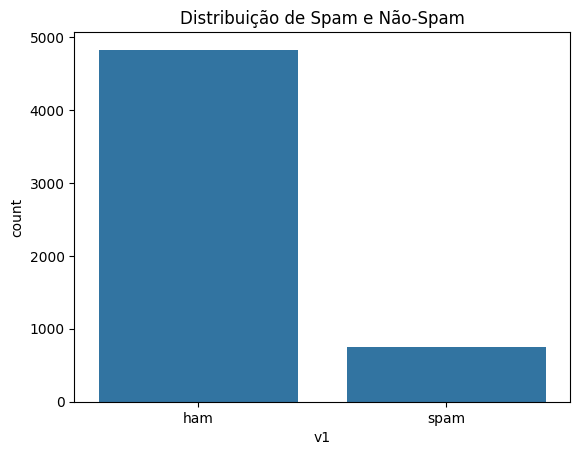

In [14]:
# Visualizar a distribuição dos valores de Spam x Não-Spam ('Ham') no dataset
sns.countplot(x='v1', data=df)
plt.title('Distribuição de Spam e Não-Spam')
plt.show()

# 3. Pré-processamento dos dataset


In [15]:
# Etapa pré-processamento do dataset
def preprocess_text(text):
    text = text.lower()  # Converter o conteúdo do texto para letras minúsculas
    text = text.translate(str.maketrans('', '', string.punctuation))  # Remover pontuação
    return text

# Aplicar pré-processamento
df['processed_text'] = df['v2'].apply(preprocess_text)

# Usar TF-IDF para transformar o texto em vetores numéricos
vectorizer = TfidfVectorizer(stop_words='english')
X = vectorizer.fit_transform(df['processed_text'])

# Rótulos
y = df['v1']

In [6]:
#verificar os valores presentes na coluna "v1"
print(df['v1'].unique())
# Verificar valores NaN
print(df['v1'].isnull().sum())

['ham' 'spam']
0


In [16]:
# Remover espaços extras das labels
df['v1'] = df['v1'].str.strip()

# Verificar novamente os valores únicos
print(df['v1'].unique())

['ham' 'spam']


In [17]:
# Mapear as labels 'spam' e 'ham' para valores numéricos
spam_mapping = {'spam': 2,'ham': 1}
df['v1'] = df['v1'].map(spam_mapping)
# Verificar a transformação
print(df.head())

   v1                                                 v2 Unnamed: 2  \
0   1  Go until jurong point, crazy.. Available only ...        NaN   
1   1                      Ok lar... Joking wif u oni...        NaN   
2   2  Free entry in 2 a wkly comp to win FA Cup fina...        NaN   
3   1  U dun say so early hor... U c already then say...        NaN   
4   1  Nah I don't think he goes to usf, he lives aro...        NaN   

  Unnamed: 3 Unnamed: 4                                     processed_text  
0        NaN        NaN  go until jurong point crazy available only in ...  
1        NaN        NaN                            ok lar joking wif u oni  
2        NaN        NaN  free entry in 2 a wkly comp to win fa cup fina...  
3        NaN        NaN        u dun say so early hor u c already then say  
4        NaN        NaN  nah i dont think he goes to usf he lives aroun...  


KNN - Acurácia : 0.9794
Random Forest - Acurácia : 0.9783
SVM - Acurácia : 0.9838
Decision Tree - Acurácia : 0.8614
Logistic Regression - Acurácia : 0.9722
Naive Bayes - Acurácia : 0.7891


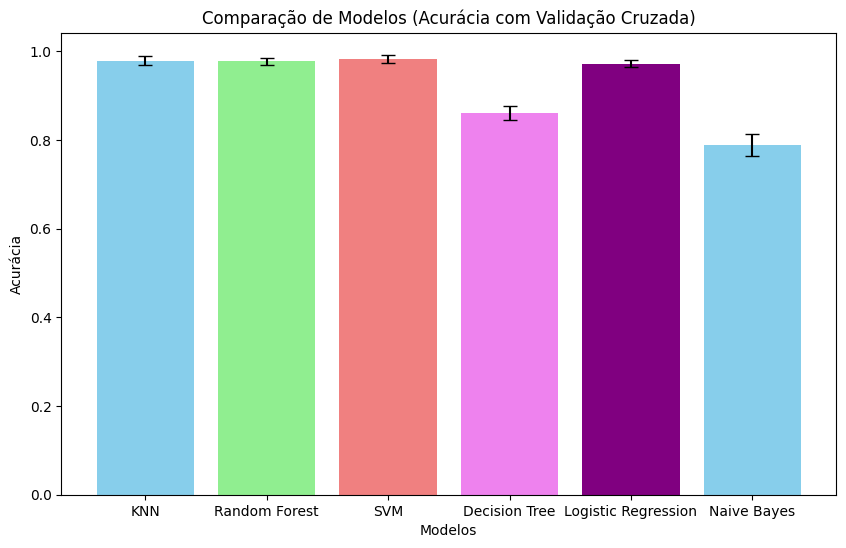

In [20]:
# Converter as mensagens de texto em vetores numéricos usando CountVectorizer
from sklearn.feature_extraction.text import CountVectorizer
vectorizer = CountVectorizer(stop_words='english')
X = vectorizer.fit_transform(data['message']).toarray()  # Transformar em array
y = data['label']

# Padronizar os dados (necessário especialmente para SVM)
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Aplicar o undersampling para balancear as classes
undersampler = RandomUnderSampler(sampling_strategy='auto', random_state=42)
X_resampled, y_resampled = undersampler.fit_resample(X_scaled, y)

# Definir o número de folds para validação cruzada
kfold = StratifiedKFold(n_splits=10, shuffle=True, random_state=42)

# Definir os classificadores
models = {
    'KNN': KNeighborsClassifier(),
    'Random Forest': RandomForestClassifier(),
    'SVM': SVC(),
    'Decision Tree': DecisionTreeClassifier(),
    'Logistic Regression': LogisticRegression(max_iter=1000),  # max_iter ajustado para garantir convergência
    'Naive Bayes':GaussianNB()
}

# Listas para armazenar os resultados
model_names = []
mean_accuracies = []
std_devs = []

# Aplicar validação cruzada
for name, model in models.items():
    cv_scores = cross_val_score(model, X_scaled, y, cv=kfold, scoring='accuracy')
    model_names.append(name)
    mean_accuracies.append(cv_scores.mean())
    std_devs.append(cv_scores.std())

# Exibir os valores numéricos das acurácias médias e desvios padrão
for name, mean_acc, std in zip(model_names, mean_accuracies, std_devs):
    print(f"{name} - Acurácia : {mean_acc:.4f}")

# Criando o gráfico comparativo
plt.figure(figsize=(10, 6))
plt.bar(model_names, mean_accuracies, yerr=std_devs, capsize=5, color=['skyblue', 'lightgreen', 'lightcoral', 'violet', 'purple'])
plt.title('Comparação de Modelos (Acurácia com Validação Cruzada)')
plt.xlabel('Modelos')
plt.ylabel('Acurácia')
plt.show()


# 5. Conclusões


# 6. Próximos passos

